<h1>C4 Solution</h1>

<h3>Get the data and copy it to S3</h3>

In [184]:
# TODO: Install any packages that you might need
# I will need the smdebug package
!pip install smdebug
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [185]:
# TODO: Import all necessary packages that you might need
# For instance I will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, Rule, ProfilerRule, rule_configs, TensorBoardOutputConfig
from sagemaker.pytorch import PyTorch
from sagemaker.predictor import Predictor
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.debugger import CollectionConfig
from sagemaker.pytorch import PyTorchModel
import os
import numpy as np

In [186]:
sess = sagemaker.Session()
bucket = sess.default_bucket()                                ## TODO: fill in
print("Default Bucket: {}".format(bucket))

my_session = boto3.session.Session()
region = my_session.region_name## TODO: fill in
print("AWS Region: {}".format(region))


role = get_execution_role()## TODO: fill in
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-324194532919
AWS Region: us-east-1
RoleArn: arn:aws:iam::324194532919:role/service-role/AmazonSageMaker-ExecutionRole-20220220T161955


In [ ]:
# Upload data to S3 bucket.
inputs = sagemaker_session.upload_data(path=datapath, bucket=data_bucket, key_prefix=datapath)
print(inputs)

<h3>Set up parameters, estimator, and tuner</h3>

In [165]:
#TODO: Declare your HP ranges, metrics etc.

from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [166]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="fm_hpo.py",
    base_job_name="pytorch_fashionmnist",
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8.0",
    py_version="py36"
)# TODO: Your estimator here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)
# TODO: Your HP tuner here

<h3>Fit the tuner</h3>

In [167]:

s3_data = "s3://{}/{}/".format(bucket, "images")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")


os.environ['SM_CHANNEL_TRAIN']=s3_data
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir


tuner.fit({'train' : s3_data},wait=True) 

.................................................................................................................................................................................................................................................................................................................................................................!


In [168]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hypers = best_estimator.hyperparameters()

# To know exact data from best_estimator.hyperparameters()
print(best_hypers)


2022-02-21 15:27:18 Starting - Preparing the instances for training
2022-02-21 15:27:18 Downloading - Downloading input data
2022-02-21 15:27:18 Training - Training image download completed. Training in progress.
2022-02-21 15:27:18 Uploading - Uploading generated training model
2022-02-21 15:27:18 Completed - Training job completed
{'_tuning_objective_metric': '"Test Loss"', 'batch_size': '"32"', 'lr': '0.03138192028805053', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch_fashionmnist-2022-02-21-15-03-22-137"', 'sagemaker_program': '"fm_hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-324194532919/pytorch_fashionmnist-2022-02-21-15-03-22-137/source/sourcedir.tar.gz"'}


In [169]:
with open ('best_hypers.txt', 'w') as f:
    f.write(str(best_hypers))


<h3>Describe the tuning results</h3>


<h3>Prepare to perform Training on Best Estimator</h3>

In [170]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.03138192028805053',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_fashionmnist-2022-02-21-15-03-22-137"',
 'sagemaker_program': '"fm_hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-324194532919/pytorch_fashionmnist-2022-02-21-15-03-22-137/source/sourcedir.tar.gz"'}

In [172]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import CollectionConfig
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
#how to set up debbugging, collectionconfigs
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]
debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [173]:
# TODO: Create and fit an estimator
#import os
hyperparameters = {"batch_size": "32", "lr": "0.03138192028805053"} 
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="fm_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

#estimator = estimator.fit(wait=True)# TODO: Your estimator here
#in your notebook, you should specify the location of your training data:(this is from knowledge)
estimator.fit({'train':s3_data}, wait=True)

2022-02-21 15:35:29 Starting - Starting the training job...
2022-02-21 15:35:31 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-02-21 15:37:18 Starting - Preparing the instances for training...
2022-02-21 15:37:58 Downloading - Downloading input data.............................................
2022-02-21 15:45:20 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-21 15:45:36,599 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-21 15:45:36,620 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-21 15:45:39,645 sagemaker_pytorch_container.training INFO     Invoking user training script.

2022-02-21 15:46:00 Training - Training image download c

In [174]:
# TODO: Plot a debugging output.
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-02-21-15-35-29-062
Region: us-east-1
[2022-02-21 15:49:47.758 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:425 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-15-35-29-062/debug-output
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
132
876


In [175]:
tensor_name = "CrossEntropyLoss_output_0"

In [178]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [179]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490,
  500,
  510,
  520,
  530,
  540,
  550,
  560,
  570,
  580,
  590,
  600,
  610,
  620,
  630,
  640,
  650,
  660,
  670,
  680,
  690,
  700,
  710,
  720,
  730,
  740,
  750,
  760,
  770,
  780,
  790,
  800,
  810,
  820,
  830,
  840,
  850,
  860,
  870,
  880,
  890,
  900,
  910,
  920,
  930,
  940,
  950,
  960,
  970,
  980,
  990,
  1000,
  1010,
  1020,
  1030,
  1040,
  1050,
  1060,
  1070,
  1080,
  1090,
  1100,
  1110,
  1120,
  1130,
  1140,
  1150,
  1160,
  1170,
  1180,
  1190,
  1200,
  1210,
  1220,
  1230,
  1240,
  1250,
  1260,
  1270,
  1280,
  1290,
  1300,
  1310],
 [array(4.9400554, dtype=float32),
  array(2.4681504, 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


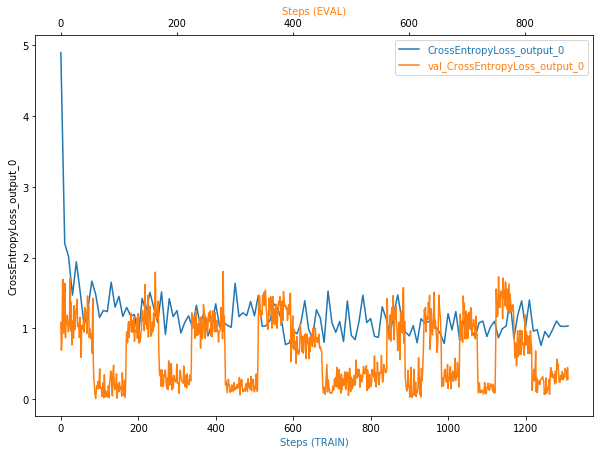

In [49]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

<h2>Creating an Estimator</h2>

In [ ]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [223]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-14-21-08-051/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-14-21-08-051/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-14-21-08-051/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-14-21-08-051/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-324194532919/

In [224]:
#import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [226]:
! tar czf ProfilerReport.tgz ProfilerReport/

# Deployment

In [257]:

model_location = 's3://{}/{}/output/model.tar.gz'.format(bucket, training_job_name)
print('model_location =', model_location)

model_location = s3://sagemaker-us-east-1-324194532919/pytorch-training-2022-02-21-15-35-29-062/output/model.tar.gz


In [258]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [259]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [269]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='fm_reference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [267]:
from time import time

In [270]:
begin = time()
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
c_time = time()-begin
print('Creating Endpoint Time: {: .01f}s'.format(c_time))

------!Creating Endpoint Time:  187.4s


In [271]:
print('endpoint_name = ',predictor.endpoint_name)

endpoint_name =  pytorch-inference-2022-02-21-19-39-39-853


In [272]:
import pandas as pd
testset = pd.read_csv('test.csv')
testset.head()

,fullname,label
0,images/test/9/Ankle-Boot_1.jpg,9
1,images/test/2/Pullover_1.jpg,2
2,images/test/1/Trouser_1.jpg,1
3,images/test/1/Trouser_2.jpg,1
4,images/test/6/Shirt_1.jpg,6


In [273]:
import pandas as pd

testset_1 = testset.iloc[:5000,:]
#testset_2 = testset.iloc[5001:,:] 
testset_1.head()

,fullname,label
0,images/test/9/Ankle-Boot_1.jpg,9
1,images/test/2/Pullover_1.jpg,2
2,images/test/1/Trouser_1.jpg,1
3,images/test/1/Trouser_2.jpg,1
4,images/test/6/Shirt_1.jpg,6


In [274]:
import random
k = random.randint(0, testset.shape[0]-1)
import io
filename = testset['fullname'][k]
label = testset['label'][1]
with open(filename, 'rb') as f:
    input = f.read()
len(input)

1001

In [148]:
output = predictor.predict(input)
output

[[0.5479651689529419,
  1.8651485443115234,
  -2.5988097190856934,
  5.487130641937256,
  1.931625485420227,
  -6.758813381195068,
  3.092844247817993,
  -2.8216121196746826,
  -1.2999895811080933,
  -0.9873822927474976]]

In [149]:
import numpy as np
prediction = np.argmax(output)
print('prediction:', prediction,', ', filename, 'label: ', label)
if prediction == label:
    print('Prediction is correct')
else:
    print('Prediction is not correct')

prediction: 3 ,  images/test/6/Shirt_586.jpg label:  2
Prediction is not correct


In [108]:
begin = time()
preds = []
for k in range(testset.shape[0]):
    filename = testset['fullname'][k]
    with open(filename, 'rb') as f:
        input = f.read()
    output = predictor.predict(input)
    preds.append(np.argmax(output))

seconds = time() - begin
mins = seconds //60
print(f'Testing time: {seconds: 0.1f}s')

Testing time:  121.9s


In [ ]:
# Record the prediction data to process later in our local machine
testset['prediction'] = preds
testset.to_csv('predictions.csv', index=False)

In [87]:
import pandas as pd
import numpy as np

In [ ]:
testset = pd.read_csv('predictions.csv')
testset.head()

In [42]:
equal_indexs = testset['label'] == testset['prediction']

In [43]:
correct_preds = testset[equal_indexs]
correct_preds.reset_index(inplace=True, drop=True)
correct_preds.head()

,fullname,label,prediction
0,images/test/9/Ankle-Boot_1.jpg,9,9
1,images/test/2/Pullover_1.jpg,2,2
2,images/test/1/Trouser_1.jpg,1,1
3,images/test/1/Trouser_2.jpg,1,1
4,images/test/6/Shirt_1.jpg,6,6


In [44]:
accu = sum(equal_indexs)/testset.shape[0]
print(f'The accuracy of all test images is: {accu:0.4f} or{accu*100: .0f}%')

The accuracy of all test images is: 0.8998 or 90%


In [45]:
cls_names = list(pd.read_csv('classes.csv')['class_name'])
cls_names

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coatadd_label',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle-Boot']

In [46]:
# We know the size of each class in testset is 1000
cls_correct = [0 for _ in range(10)]
for k in range(correct_preds.shape[0]):
    n = correct_preds['label'][k] 
    if correct_preds['prediction'][k] == n:
            cls_correct[n] += 1
cls_accu = []
for n in range(10):
    cls_accu.append(cls_correct[n]/1000)
    print(f'The accuracy of label {n} is:{cls_accu[n]: .04f} or {cls_accu[n]*100: .0f}%')
    
        

The accuracy of label 0 is: 0.8580 or  86%
The accuracy of label 1 is: 0.9780 or  98%
The accuracy of label 2 is: 0.8610 or  86%
The accuracy of label 3 is: 0.9060 or  91%
The accuracy of label 4 is: 0.8450 or  84%
The accuracy of label 5 is: 0.9590 or  96%
The accuracy of label 6 is: 0.7040 or  70%
The accuracy of label 7 is: 0.9550 or  96%
The accuracy of label 8 is: 0.9780 or  98%
The accuracy of label 9 is: 0.9540 or  95%


In [47]:
for n in range(10):
    print(f'The accuracy of class {cls_names[n]} is: {cls_accu[n]: .04f} or\t{cls_accu[n]*100: .0f}%')

The accuracy of class T-Shirt is:  0.8580 or	 86%
The accuracy of class Trouser is:  0.9780 or	 98%
The accuracy of class Pullover is:  0.8610 or	 86%
The accuracy of class Dress is:  0.9060 or	 91%
The accuracy of class Coatadd_label is:  0.8450 or	 84%
The accuracy of class Sandal is:  0.9590 or	 96%
The accuracy of class Shirt is:  0.7040 or	 70%
The accuracy of class Sneaker is:  0.9550 or	 96%
The accuracy of class Bag is:  0.9780 or	 98%
The accuracy of class Ankle-Boot is:  0.9540 or	 95%
